In [23]:
from darts.models import TiDEModel
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping as EarlyStopping_lightning
from torch.optim import lr_scheduler

In [24]:
import sys
import os

# Go up two levels from notebook (Training/MLR) to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to sys.path:", project_root)
# Ensure the model save directory exists
model_save_path = os.path.join('.')
os.makedirs(model_save_path, exist_ok=True)  # Creates directory if it doesn't exist

Project root added to sys.path: c:\Users\James\COMP5530M-Group-Project-Inflation-Forecasting


Data loading

In [25]:
import pandas as pd
from Training.Helper.dataPreprocessing import TRAIN_DATA_PATH_1990S, get_untransformed_exog
date_col = 'observation_date'

# Load and format training data (only using PCEPI)
train_df = pd.read_csv(TRAIN_DATA_PATH_1990S)
train_df = get_untransformed_exog(train_df)
# Convert the date column to datetime format
train_df[date_col] = pd.to_datetime(train_df[date_col], format='%m/%Y')

# Set the date column as the index
train_df.set_index(date_col, inplace=True)

In [26]:
from Training.Helper.dataPreprocessing import rank_features_ccf

# Ranks all non-date variables
ranked_features = rank_features_ccf(train_df)

# Define the number of features that should be used
FEATURES_TO_USE = len(ranked_features) #ensure this is all features for Optuna to work properly
used_features = ranked_features[:FEATURES_TO_USE]

In [27]:
def get_ranked_df(train_df, ranked_features, features_to_use):
    return train_df.loc[:,ranked_features[:features_to_use]]

In [28]:
import numpy as np
target_col = "fred_log"
train_df["fred_log"] = np.log(train_df["fred_PCEPI"])

train_df_ranked = get_ranked_df(train_df, ranked_features, FEATURES_TO_USE)
train_df_ranked[target_col] = train_df[target_col]

In [29]:
from darts import TimeSeries

def get_target_exogenous_series(train_df, target_col):
    target_series = TimeSeries.from_series(train_df[target_col])

    # Extract the exogenous variables (all columns except 'fred_PCEPI')
    exogenous_variables = train_df.drop(columns=[target_col])
    exogenous_series = TimeSeries.from_dataframe(exogenous_variables)
    return target_series, exogenous_series

In [33]:
from darts import TimeSeries

target_series, exogenous_series = get_target_exogenous_series(train_df, target_col)

In [34]:
target_series_ranked, exogenous_series_ranked = get_target_exogenous_series(train_df_ranked, target_col)

Basic model

In [35]:
model = TiDEModel(input_chunk_length=24, output_chunk_length=6)

# Fit the model with the target series and exogenous variables
model.fit(series=target_series,past_covariates=exogenous_series)

2025-04-23 01:23:21,613 - INFO - Train dataset contains 379 samples.
2025-04-23 01:23:21,619 - INFO - Time series values are 64-bits; casting model to float64.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 18.3 K | train
6 | encoders            | Sequential       | 47.5 K | train
7 | decoders            | Sequential       | 41.3 K | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_sk

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=24, output_chunk_length=6)

In [36]:
pred = model.predict(6)
pred.values()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[ 2704.6916761 ],
       [-4273.74765659],
       [ 2118.94651485],
       [  262.53569578],
       [  109.6996872 ],
       [  295.16909184]])

This is terrible

In [37]:
model = TiDEModel(input_chunk_length=24, output_chunk_length=6)

# Fit the model with the target series and exogenous variables
model.fit(series=target_series_ranked,past_covariates=exogenous_series_ranked)

2025-04-23 01:23:40,617 - INFO - Train dataset contains 379 samples.
2025-04-23 01:23:40,623 - INFO - Time series values are 64-bits; casting model to float64.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 18.2 K | train
6 | encoders            | Sequential       | 47.5 K | train
7 | decoders            | Sequential       | 41.3 K | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_sk

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=24, output_chunk_length=6)

In [38]:
pred = model.predict(6)
pred.values()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[1943.35566076],
       [1934.54087601],
       [-347.80358351],
       [1050.08923098],
       [1307.27749736],
       [ 924.6260535 ]])

This is a lot more reasonable - indicating that having too many features causes the model problems.

Split validation and training then scale

In [39]:
def fit_transform_TimeSeries(train_ts, val_ts, scaler):
    scaled_train = scaler.fit_transform(train_ts)
    scaled_val = scaler.transform(val_ts)
    return scaled_train, scaled_val, scaler

In [40]:
from Training.Helper.dataPreprocessing import TRAIN_DATA_SPLIT
def split_and_scale_TimeSeries(target_series, exogenous_series):
    train_target, val_target = target_series.split_after(TRAIN_DATA_SPLIT)
    train_exo, val_exo = exogenous_series.split_after(TRAIN_DATA_SPLIT)
    
    # default uses sklearn's MinMaxScaler
    scaled_train_target, scaled_val_target, targetScaler = fit_transform_TimeSeries(train_target, val_target, Scaler())
    scaled_train_exo, scaled_val_exo, exoScaler = fit_transform_TimeSeries(train_exo, val_exo, Scaler())
    return scaled_train_target, scaled_train_exo, scaled_val_target, scaled_val_exo, targetScaler, exoScaler

In [41]:
scaled_train_target, scaled_train_exo, scaled_val_target, scaled_val_exo, targetScaler, exoScaler = split_and_scale_TimeSeries(target_series, exogenous_series)
scaled_train_target_r, scaled_train_exo_r, scaled_val_target_r, scaled_val_exo_r, targetScaler_r, exoScaler_r = split_and_scale_TimeSeries(target_series_ranked, exogenous_series_ranked)

In [21]:
# needed for the plot of unscaled series later
train_target, val_target = target_series.split_after(TRAIN_DATA_SPLIT)

<Axes: xlabel='observation_date'>

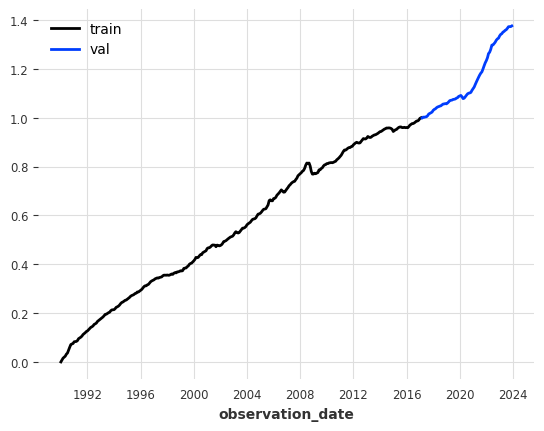

In [43]:
scaled_train_target.plot(label="train")
scaled_val_target.plot(label="val")

Basic model

In [44]:
OUT_LENGTH = 12

early_stopper = EarlyStopping_lightning(
    monitor='val_loss',
    patience=10,
    min_delta=1e-3,
    mode='min'
)
lr_scheduler_kwargs = {
    "gamma": 0.999,
}
model = TiDEModel(
    input_chunk_length=48,
    output_chunk_length=OUT_LENGTH,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    optimizer_kwargs={"lr": 1e-3},
    lr_scheduler_cls= lr_scheduler.ExponentialLR,
    lr_scheduler_kwargs = {"gamma": 0.999},
    use_reversible_instance_norm = True
)

In [45]:
import copy

model.fit(series=scaled_train_target,past_covariates=scaled_train_exo,val_series=scaled_val_target,val_past_covariates=scaled_val_exo,verbose=True)
# Make a copy of the model for potential later use
original_model = copy.deepcopy(model)

2025-04-23 01:24:55,953 - INFO - Train dataset contains 267 samples.
2025-04-23 01:24:55,957 - INFO - Time series values are 64-bits; casting model to float64.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type             | Params | Mode 
------------------------------------------------------------------
0  | criterion           | MSELoss          | 0      | train
1  | train_criterion     | MSELoss          | 0      | train
2  | val_criterion       | MSELoss          | 0      | train
3  | train_metrics       | MetricCollection | 0      | train
4  | val_metrics         | MetricCollection | 0      | train
5  | rin                 | RINorm           | 2      | train
6  | past_cov_projection | _ResidualBlock   | 18.3 K | train
7  | encoders            | Sequential       | 78.2 K | train
8  | decoders            | Sequential       | 66.0 K | train
9  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [46]:
# prediction_size must be <= OUT_LENGTH
prediction_size = OUT_LENGTH
predictions = model.predict(prediction_size, verbose=False)
transformed_predictions = targetScaler.inverse_transform(predictions)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [47]:
model.output_chunk_length

12

Metrics for first model without hyperparameter optimisation:


,RMSE,MAE,r2
TiDE,0.008559,0.007736,-1.000011


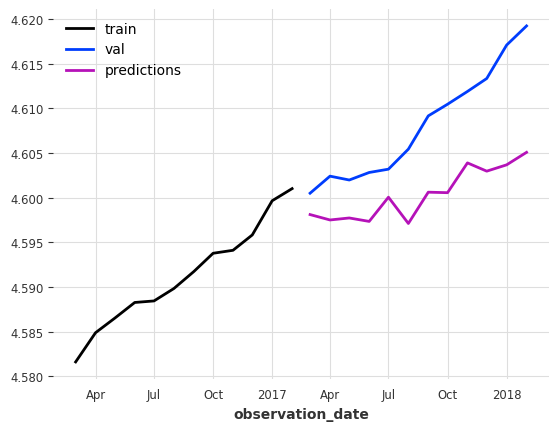

In [48]:
from darts.metrics import mse
from Evaluation.Helper.evaluation_helpers import calc_metrics_arrays

train_target[-prediction_size:].plot(label='train')
val_target[:prediction_size].plot(label='val')
transformed_predictions.plot(label='predictions')
original_model_metrics = calc_metrics_arrays(val_target[:prediction_size].values(), transformed_predictions.values(), model_names=['TiDE'])
print('Metrics for first model without hyperparameter optimisation:')
display(original_model_metrics)

The discontinuity in the above plot between the ground-truth training and validation sets looks incorrect, but that is simply because a natural slight downturn occurred between the two months in question at the end of the training period and the beginning of the validation period respectively.

Not that good so optuna test

In [49]:
# This is currently not used, but could be switched to
split_date = pd.Timestamp('2022-12')
op_train , op_val = target_series.split_after(split_date)
op_train_exo , op_val_exo = exogenous_series.split_after(split_date)

In [50]:
from darts.metrics import mse
from Training.Helper.PyTorchModular import optuna_trial_get_kwargs

def get_optuna_ranked_series(trial, scaled_train_exo, scaled_val_exo, ranked_features):
    n_features = optuna_trial_get_kwargs(trial, {'n': (int, 1, scaled_train_exo.n_components)})['n']
    return scaled_train_exo.drop_columns(ranked_features[n_features:]), scaled_val_exo.drop_columns(ranked_features[n_features:])

In [51]:
import optuna
from darts.metrics import mse
from Training.Helper.PyTorchModular import optuna_trial_get_kwargs

model_search_space = {
    'input_chunk_length': (int, 24, 60),
    'num_encoder_layers': (int, 1, 3),
    'num_decoder_layers': (int, 1, 3),
    'hidden_size': (int, 64, 512),
    'dropout': (float, 0.1, 0.5, {'log': True}),
    'optimizer_kwargs': {"lr": (float, 1e-4, 1e-2)},
    'lr_scheduler_kwargs': {"gamma": (float, 0.9, 1.0)},
    'use_reversible_instance_norm': ('categorical', [True, False]),
}

# Controlling input chunk length for now to decrease the size of the search space
model_invariates = {
    #'input_chunk_length': 48,
    'output_chunk_length': 12,
    'lr_scheduler_cls': lr_scheduler.ExponentialLR,
    'pl_trainer_kwargs': {"callbacks": [early_stopper]}
}

def objective(trial):

    model_kwargs = optuna_trial_get_kwargs(trial, model_search_space)

    scaled_train_exo_ranked, scaled_val_exo_ranked = get_optuna_ranked_series(trial, scaled_train_exo_r, scaled_val_exo_r, ranked_features)

    # Initialize the TiDEModel with suggested hyperparameters
    model = TiDEModel(**model_kwargs, **model_invariates)

    # Fit the model
    model.fit(series = scaled_train_target,
              past_covariates = scaled_train_exo_ranked,
              val_series = scaled_val_target,
              val_past_covariates = scaled_val_exo_ranked,
              epochs=1000,
              verbose = False)

    # Evaluate the model
    # (this is an alternative option for evaluation, where the model must predict the final prediction_size elements of the validation data having been given all other validation data;
    #  if switching to this method, ensure that final prediction is performed with the same setup (this is currently done just by predicting the next n values))
    #scaled_val_predictions = model.predict(n=prediction_size,series=scaled_val_target[:-prediction_size],past_covariates=scaled_val_exo[:-prediction_size], verbose=False)]
    #val_predictions = targetScaler.inverse_transform(scaled_val_predictions, verbose=False)
    #error = mse(val_target[-prediction_size:], val_predictions, verbose=False)

    # Raw output is scaled, so inverse transform to become comparable with validation set
    scaled_val_predictions = model.predict(n=prediction_size, verbose=False)
    val_predictions = targetScaler.inverse_transform(scaled_val_predictions, verbose=False)
    # Only uses the first prediction_size values of val_target, since this is the size of the prediction made by the model
    error = mse(val_target[:prediction_size], val_predictions, verbose=False)
    return error

In [52]:
# Create an Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

[I 2025-04-23 01:25:13,216] A new study created in memory with name: no-name-388177a2-138a-4cc1-8c5a-166d6205438c
2025-04-23 01:25:13,230 - INFO - Train dataset contains 269 samples.
2025-04-23 01:25:13,236 - INFO - Time series values are 64-bits; casting model to float64.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-04-23 01:25:13,581] Trial 0 finished with value: 0.2883117935814283 and parameters: {'input_chunk_length': 46, 'num_encoder_layers': 2, 'num_decoder_layers': 1, 'hidden_size': 237, 'dropout': 0.26506265933349155, 'lr': 0.005239910017214985, 'gamma': 0.97392621751701, 'use_reversible_instance_norm': False, 'n': 98}. Best is trial 0 with value: 0.2883117935814283.
2025-04-23 01:25:13,595 - INFO - Trai

In [53]:
# Testing the generalised function - works for now but no find-best-feature-split functionality
from Training.Helper.PyTorchModular import optuna_tune_and_train_darts

amazing_model = optuna_tune_and_train_darts(TiDEModel,
                                            scaled_train_target, scaled_val_target, scaled_train_exo, scaled_val_exo,
                                            model_search_space, model_invariates,
                                            n_trials=5, n_epochs_per_trial=50)

[I 2025-04-23 01:25:24,394] A new study created in memory with name: TiDEModel_hyperparameter_optimisation
2025-04-23 01:25:24,405 - INFO - Train dataset contains 275 samples.
2025-04-23 01:25:24,411 - INFO - Time series values are 64-bits; casting model to float64.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-04-23 01:25:24,832] Trial 0 finished with value: 6.676443923072913 and parameters: {'input_chunk_length': 40, 'num_encoder_layers': 3, 'num_decoder_layers': 1, 'hidden_size': 248, 'dropout': 0.261556857729578, 'lr': 0.009017029178584083, 'gamma': 0.9550869196098072, 'use_reversible_instance_norm': False}. Best is trial 0 with value: 6.676443923072913.
2025-04-23 01:25:24,842 - INFO - Train dataset contains

In [54]:
study.best_params

{'input_chunk_length': 55,
 'num_encoder_layers': 3,
 'num_decoder_layers': 3,
 'hidden_size': 211,
 'dropout': 0.11753180782877559,
 'lr': 0.0018104000394722826,
 'gamma': 0.9989199169640082,
 'use_reversible_instance_norm': True,
 'n': 18}

In [55]:
from Training.Helper.PyTorchModular import reformat_best_params
# Retrieve the best hyperparameters
best_params = study.best_params
# Get the 'n' parameter out of the best_params dictionary and extract just the value
best_n_features = reformat_best_params(best_params, {'n': (int, (1, 2))})['n']
# Format parameters returned by study into the same style as the search space definition (can be passed straight into model as kwargs)
best_params = reformat_best_params(best_params, model_search_space)
print('Best hyperparameters:')
display(best_params)
print('Best number of features to include:', best_n_features)

Best hyperparameters:


{'input_chunk_length': 55,
 'num_encoder_layers': 3,
 'num_decoder_layers': 3,
 'hidden_size': 211,
 'dropout': 0.11753180782877559,
 'optimizer_kwargs': {'lr': 0.0018104000394722826},
 'lr_scheduler_kwargs': {'gamma': 0.9989199169640082},
 'use_reversible_instance_norm': True}

Best number of features to include: 18


### Load the best parameters into a model and test

In [56]:
# Initialize the TiDEModel with suggested hyperparameters
best_model = TiDEModel(**best_params, **model_invariates)

In [ ]:
# Fossilised suggested hyperparameters
    # Define early stopping callback
#early_stopper = EarlyStopping_lightning(
#    monitor='val_loss',
#    patience=10,
#    min_delta=1e-3,
#    mode='min'
#)
#model = TiDEModel(
#    input_chunk_length=29,
#    output_chunk_length=12,
#    num_encoder_layers=3,
#    num_decoder_layers=2,
#    hidden_size=443,
#    dropout= 0.19411763114257125,
#    optimizer_kwargs={"lr": 0.00014544898516544107},
#    lr_scheduler_cls=torch.optim.lr_scheduler.ExponentialLR,
#    lr_scheduler_kwargs={"gamma": 0.9645025339005199},
#    pl_trainer_kwargs={"callbacks": [early_stopper]},
#)

In [57]:
# Fit the model
#best_model.fit(series=scaled_train_target,past_covariates=scaled_train_exo, val_series=scaled_val_target, val_past_covariates=scaled_val_exo)
best_model.fit(series=scaled_train_target,
               past_covariates=scaled_train_exo.drop_columns(ranked_features[best_n_features:]),
               val_series=scaled_val_target,
               val_past_covariates=scaled_val_exo.drop_columns(ranked_features[best_n_features:]))

2025-04-23 01:25:34,556 - INFO - Train dataset contains 260 samples.
2025-04-23 01:25:34,564 - INFO - Time series values are 64-bits; casting model to float64.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type             | Params | Mode 
------------------------------------------------------------------
0  | criterion           | MSELoss          | 0      | train
1  | train_criterion     | MSELoss          | 0      | train
2  | val_criterion       | MSELoss          | 0      | train
3  | train_metrics       | MetricCollection | 0      | train
4  | val_metrics         | MetricCollection | 0      | train
5  | rin                 | RINorm           | 2      | train
6  | past_cov_projection | _ResidualBlock   | 5.1 K  | train
7  | encoders            | Sequential       | 429 K  | train
8  | decoders            | Sequential       | 394 K  | train
9  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TiDEModel(output_chunk_shift=0, num_encoder_layers=3, num_decoder_layers=3, decoder_output_dim=16, hidden_size=211, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.11753180782877559, use_static_covariates=True, input_chunk_length=55, optimizer_kwargs={'lr': 0.0018104000394722826}, lr_scheduler_kwargs={'gamma': 0.9989199169640082}, use_reversible_instance_norm=True, output_chunk_length=12, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000168E66B5B10>]})

In [58]:
# Predict over the test horizon
TEST_HORIZON = 12
val_predictions = best_model.predict(n=TEST_HORIZON)
transformed_predictions = targetScaler.inverse_transform(val_predictions)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'Actual vs. TiDE Predicted PCE'}, xlabel='Date', ylabel='Inflation'>

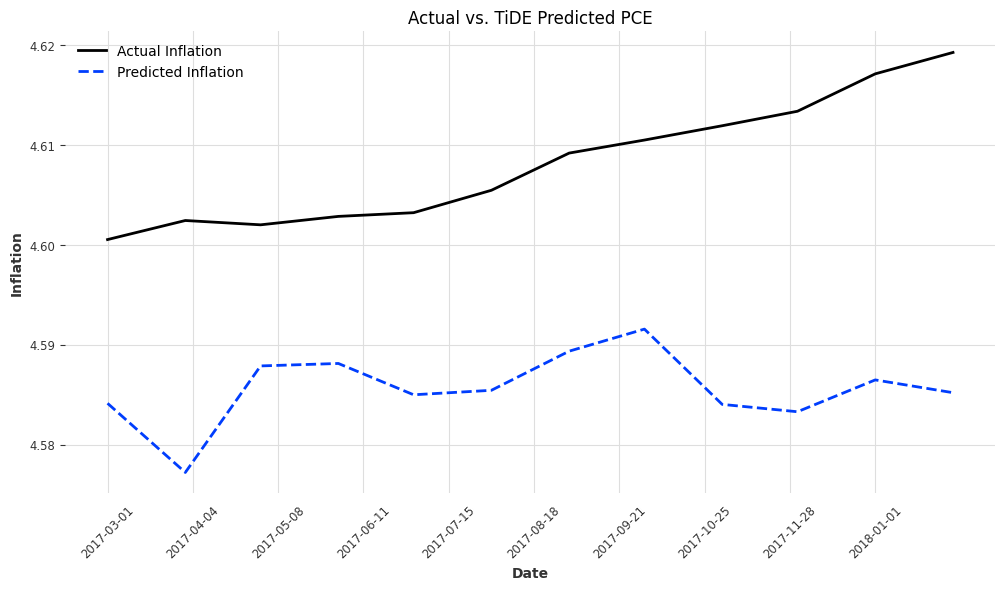

In [59]:
from Evaluation.Helper.evaluation_helpers import display_results

actuals = val_target[:TEST_HORIZON].values()
preds = transformed_predictions.values()

display_results(actuals, preds, val_target[:TEST_HORIZON].time_index, 'TiDE')

In [60]:
# Evaluate the model
print(f'Optuna trained model metrics on validation set:')
best_model_metrics = calc_metrics_arrays(actuals, preds, model_names=['TiDE'])
display(best_model_metrics)

Optuna trained model metrics on validation set:


,RMSE,MAE,r2
TiDE,0.023417,0.022499,-13.969171


In [61]:
display(original_model_metrics, best_model_metrics)

,RMSE,MAE,r2
TiDE,0.008559,0.007736,-1.000011


,RMSE,MAE,r2
TiDE,0.023417,0.022499,-13.969171


In [62]:
# Find the model from the that has the best RMSE and take that as the best
ranked_best = True
if original_model_metrics.values.flatten()[0] < best_model_metrics.values.flatten()[0]:
    best_model = original_model
    ranked_best = False

In [63]:
best_model.save("tide.pkl")

Go from here if wanting to load model

In [64]:
from darts.models import TiDEModel

# Load the model from the file
model = TiDEModel.load("tide.pkl")

In [69]:
# Finally, predict 12 months into the future from the end of the training dataset
scaled_total = targetScaler.transform(target_series)
scaled_total_exo = exoScaler.transform(exogenous_series)

if ranked_best:
    scaled_total_exo = scaled_total_exo.drop_columns(ranked_features[best_n_features:])

# may error here if the 
pred = model.predict(TEST_HORIZON,series=scaled_total,past_covariates=scaled_total_exo)
finalout = targetScaler.inverse_transform(pred)
final = np.exp(finalout.values())
print(f'Final predictions:\n{final}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Final predictions:
[[128.9403985 ]
 [129.70668867]
 [129.43715806]
 [130.0205677 ]
 [132.50812789]
 [128.51098996]
 [131.66130405]
 [134.55196149]
 [132.23473999]
 [132.37335953]
 [134.46545348]
 [133.23723062]]


In [43]:
import numpy as np
np.save(os.path.join(project_root, 'Predictions', 'Tide.npy'), finalout.values().flatten())

In [72]:
horizion3 = []
for i in range(4):
    pred = model.predict(n=3,series=scaled_total,past_covariates=scaled_total_exo)
    horizion3.append(pred)
    
    # Extend the series with the latest prediction for next iteration
    scaled_total = scaled_total.append(pred)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

2025-04-23 02:21:22,907 - ERROR - ValueError: For the given forecasting horizon `n=3`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n <= output_chunk_length` the past covariates must end at time step `2024-03-01 00:00:00`, whereas now they end at time step `2023-12-01 00:00:00`.


ValueError: For the given forecasting horizon `n=3`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n <= output_chunk_length` the past covariates must end at time step `2024-03-01 00:00:00`, whereas now they end at time step `2023-12-01 00:00:00`.